**Install and import dependencies**


In [1]:
from obspy import read
import numpy as np
import matplotlib.pyplot as plt
import torch

**Ensure CUDA is enabled for hardware accelerated training**

In [4]:
from warnings import warn
if not torch.cuda.is_available():
    warn("No hardware acceleration is being used. Install CUDA or ensure the runtime type is set to GPU if using google colab")
else:
    print("Torch with CUDA is enabled")

Torch with CUDA is enabled


**Replace SGY_PATH with the path to the SEGY file in the mounted google drive account**

In [ ]:
SGY_PATH = "./SeismicData/Seismic_data.sgy"
st = read(SGY_PATH, format="SEGY")

**Normalize all amplitude values from -1 to 1 for model interpretation**

In [9]:
for tr in st:
    tr.normalize()

**Calculate number of inlines and crosslines measured**

In [10]:
inline_length = max(trace.stats.segy.trace_header.trace_sequence_number_within_line for trace in st)
crossline_length = len(st) // (inline_length + 1)
sample_depth_length = len(st[0].data)

print("Num Inlines:", inline_length)
print("Num_Crosslines", crossline_length)
print("Sample depth length:", sample_depth_length)

Num Inlines: 951
Num_Crosslines 630
Sample depth length: 462


**Convert into Numpy array with axes as (depth, crossline, inline)**

In [11]:
seismic_3d_array = np.zeros(
    (inline_length + 1, crossline_length + 1, sample_depth_length)
)

# Populate the 3D array
for i, trace in enumerate(st):
    inline = trace.stats.segy.trace_header.trace_sequence_number_within_line
    crossline = i % (
        crossline_length + 1
    )  # Calculate crossline dynamically based on iteration
    seismic_3d_array[inline, crossline, :] = trace.data

print(seismic_3d_array.shape)

(952, 631, 462)


Text(0, 0.5, 'Depth')

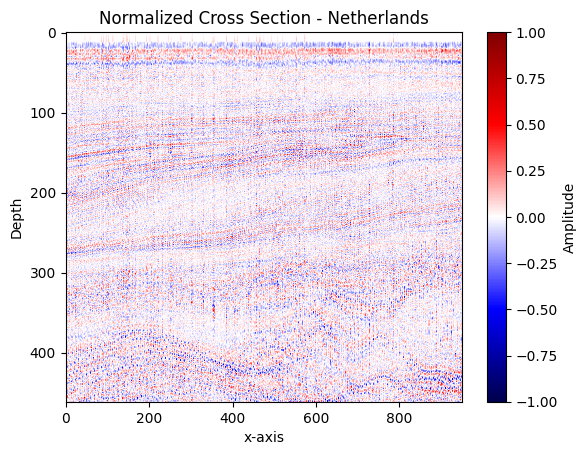

In [20]:
#Now that the seismic data is converted into a 3d array, we can plot the first crossline

first_crossline = seismic_3d_array[:, 0, :]

seismic_image = np.flipud(np.rot90(first_crossline))

# Plot the normalized crossline
plt.imshow(seismic_image, cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section - Netherlands")
plt.xlabel("x-axis")
plt.ylabel("Depth")

In [ ]:
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        